In [1]:
import numpy as np
np.random.seed(27)
import tensorflow as tf
tf.random.set_seed(27)
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import time

In [2]:
X = np.load('../data/source/x_test.npy')
Y = np.load('../data/source/y_test.npy')

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.9, random_state=27)
x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, stratify=y_train, test_size=0.3, random_state=27)
print(np.bincount(y_test.astype('int32')))
print(np.bincount(y_val.astype('int32')))
print(np.bincount(y_train.astype('int32')))

[270000 270000 270000 270000]
[21000 21000 21000 21000]
[9000 9000 9000 9000]


In [4]:
# Custome Loss and Metrics
class MaskedBinaryAccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")   
   
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        mask = tf.where(y_true!=2)
        y_true = tf.gather_nd(y_true, mask)
        y_pred = tf.gather_nd(y_pred, mask)
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        y_pred = tf.where(tf.less(y_pred, 0.5), 0., 1.)
        metric = tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(metric), tf.float32)) 

    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

class MaskedBXE(tf.keras.losses.Loss):
    def __init__(self, scale=1., **kwargs):
        self.scale = scale
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        mask = tf.where(y_true!=2)
        y_true = tf.gather_nd(y_true, mask)
        y_pred = tf.gather_nd(y_pred, mask)
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return self.scale * tf.reduce_mean(loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

class MaskedCXE(tf.keras.losses.Loss):
    def __init__(self, ignore=None, scale=1., **kwargs):
        self.ignore = ignore
        self.scale = scale
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        mask = tf.where(y_true!=self.ignore)
        y_true = tf.gather_nd(y_true, mask)
        y_pred = tf.gather_nd(y_pred, mask)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return self.scale * tf.reduce_mean(loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "ignore": self.ignore}

class MaskedCategoricalAccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, ignore=None, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        self.ignore = ignore     
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        mask = tf.where(y_true!=self.ignore)
        y_true = tf.gather_nd(y_true, mask)
        y_pred = tf.gather_nd(y_pred, mask)
        y_pred = tf.cast(tf.argmax(y_pred, axis=1), dtype=tf.float32)
        y_pred = tf.squeeze(y_pred)
        metric = tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(metric), tf.float32))   
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "ignore": self.ignore}

In [5]:
def test_single_task_model(y_test, x_test, model=None, name=None):
    test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(2**14).prefetch(tf.data.experimental.AUTOTUNE)
    y_pred = []
    for x_s in test_ds:
        _, yhat = model(x_s, training=False)
        y_pred.append(np.argmax(yhat, axis=-1))
            
    y_pred = np.concatenate(y_pred)
    acc = np.sum(y_test == y_pred) / y_test.shape[0]
    
    target_names = ['wheat', 'corn', 'rice', 'other']
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.savefig(name)
    plt.show()
    return acc

In [6]:
def test_base_model(y_test, x_test, model=None, name=None):
    test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(2**14).prefetch(tf.data.experimental.AUTOTUNE)
    y_pred = []
    for x_s in test_ds:
        yhat = model(x_s, training=False)
        y_pred.append(np.argmax(yhat, axis=-1))
            
    y_pred = np.concatenate(y_pred)
    acc = np.sum(y_test == y_pred) / y_test.shape[0]
    
    target_names = ['wheat', 'corn', 'rice', 'other']
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.savefig(name)
    plt.show()
    return acc

In [7]:
def test_multitask_model(y_test, x_test, model=None, name=None):
    test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(2**14).prefetch(tf.data.experimental.AUTOTUNE)
    y_pred = []
    for x_s in test_ds:
        _, _, _, yhat = model(x_s, training=False)
        y_pred.append(np.argmax(yhat, axis=-1))
            
    y_pred = np.concatenate(y_pred)
    acc = np.sum(y_test == y_pred) / y_test.shape[0]
    
    target_names = ['wheat', 'corn', 'rice', 'other']
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.savefig(name)
    plt.show()
    return acc

In [44]:
# Plot Progress of training and results
def plot_progress(prog, save=False, name=None):
    scale = np.round(np.log10(np.max(prog['val_loss'])))
    print('validation loss has been scaled by:', np.power(10, -scale))
    prog['val_loss'] = np.array(prog['val_loss']) * np.power(10, -scale)
    pd.DataFrame(prog).plot(figsize=(8,8))
    plt.xlim([-.5, len(prog['val_loss'])+.5])
    plt.vlines(np.argmax(prog['val_acc']), -0.01, 1.2, colors='k', linestyles='--', label='best epoch')
    plt.legend(loc='best')
    if save:
        plt.savefig(name)
    plt.show()

# Baseline

In [28]:
def get_base_model():
    tf.keras.backend.clear_session()
    base_model = tf.keras.Sequential([
        layers.Input(shape=(10, 7)),
        layers.Conv1D(32, 1, name='conv_1'),
        layers.BatchNormalization(name='bn_1'),
        layers.LeakyReLU(name='act_1'),
        layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1'),
        layers.LSTM(64, return_sequences=False, name='lstm_2'),
        layers.BatchNormalization(name='bn_2'),
        layers.Dense(32, name='dense_1'),
        layers.BatchNormalization(name='bn_3'),
        layers.LeakyReLU(name='act_2'),
        layers.Dropout(0.25, name='drop_1'),
        layers.Dense(4, activation='softmax', name='out')
    ])
    return base_model

In [29]:
base_model = get_base_model()
EPOCHS=1000
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics
crop_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# datasets and training settings
batch_size = 2**14
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=2**17).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train computation graphs
@tf.function
def train_step(x, y_c):
    with tf.GradientTape() as tape:
        y_pred_crop = base_model(x, training=True)
        loss_crop = crop_loss_fn(y_c, y_pred_crop)
        total_loss = loss_crop + sum(base_model.losses)
    grads = tape.gradient(total_loss, base_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, base_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    return loss_crop

# validation computation graphs
@tf.function
def val_step(x, y):
    val_pred = base_model(x, training=False)
    loss = val_loss_fn(y, val_pred)
    val_acc_metric.update_state(y, val_pred)
    return loss

In [30]:
best_weights = None
max_val_acc = 0.0
counter = 0
val_losses = []
crop_losses = []
progress = {'crop_loss':[], 'crop_acc':[], 'val_loss':[], 'val_acc':[]}
patience = 25
start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        train_loss = train_step(x_batch_train, y_batch_train)
        crop_losses.append(train_loss)
    
    # validation
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)
        val_losses.append(val_loss)
    
    # preserve the best model
    this_epoch_val_acc = val_acc_metric.result().numpy()
    if this_epoch_val_acc > (max_val_acc + 0.000):
        best_weights = base_model.get_weights()
        max_val_acc = this_epoch_val_acc
        counter = 0
    else:
        counter += 1
    
    # if no progress after 25 epochs reduce the learning rate
    if counter >= patience:
        if optimizer.lr.numpy() > 0.00005:
            optimizer.lr = max(0.00005, 0.5 * optimizer.lr.numpy())
            counter = 0
        else:
            break
    
    # Handling metrics and progress
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['val_acc'].append(val_acc_metric.result().numpy())
    progress['val_loss'].append(np.mean(val_losses))
    
    # reset metrics for the next epoch
    crop_losses = []
    val_losses = []
    crop_acc_metric.reset_states()
    val_acc_metric.reset_states()
    
   
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print('learning rate: ', optimizer.lr.numpy())
    print('#epochs not improved: ', counter)
    best_epoch = int(np.argmax(progress['val_acc']))
    print("Best Epoch: %d" % (best_epoch+1,))
    print("Best Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)
    

print(epoch, '/', EPOCHS)
print('learning rate: ', optimizer.lr.numpy())
best_epoch = int(np.argmax(progress['val_acc']))
print("Best Epoch: %d" % (best_epoch+1,))
print("Crop training accuracy: %.4f" % (progress['crop_acc'][best_epoch],))
print("Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
print("Validation loss: %.4f" % (progress['val_loss'][best_epoch],))
print("Total training time: %.2fs" % (time.time() - start_time))

560 / 1000
learning rate:  5e-05
Best Epoch: 511
Crop training accuracy: 0.9649
Validation acc: 0.9664
Validation loss: 0.1020
Total training time: 304.78s


In [31]:
base_model.set_weights(best_weights)

              precision    recall  f1-score   support

       wheat       0.96      0.95      0.95    270000
        corn       0.97      0.96      0.97    270000
        rice       0.99      0.99      0.99    270000
       other       0.94      0.97      0.96    270000

    accuracy                           0.97   1080000
   macro avg       0.97      0.97      0.97   1080000
weighted avg       0.97      0.97      0.97   1080000



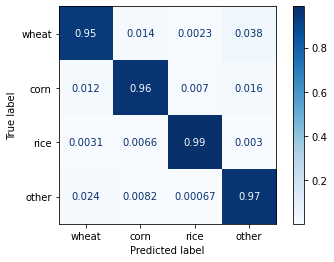

0.9663416666666667

In [32]:
test_base_model(y_test, x_test, base_model, name='normal_base_model_300epochs.png')

validation loss has been scaled by: 1.0


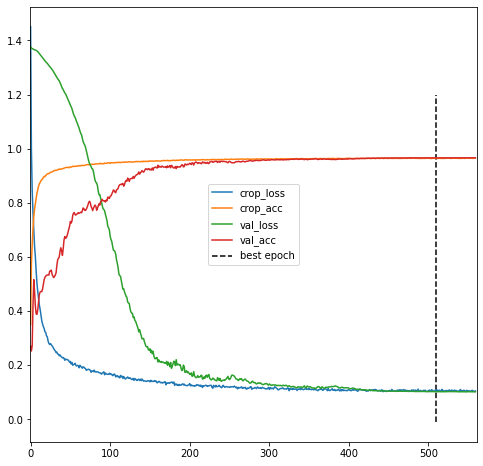

In [33]:
plot_progress(progress.copy(), save=True, name='progress_base.png')

# Baseline + Rotation

In [13]:
def get_rot_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7])
    # trunk
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_4')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)
    
    # head 1 --> reconstruction task
    rot_x = layers.Dense(1, activation='sigmoid', name='rotation')(shared_x)

    # head 2 --> classifier
    cls_x = layers.Dense(4, activation='softmax', name='crop')(shared_x)

    rot_model = tf.keras.Model(inputs=input_x, outputs=[rot_x, cls_x])
    return rot_model

In [14]:
class RotationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, x_unlabeled, batch_size_u=2000, batch_size_s=60):
        self.x_crop = x
        self.y_crop = y
        self.x_unlabeled = x_unlabeled
        self.batch_size_u = batch_size_u
        self.batch_size_s = batch_size_s
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size_u))
    
    def __getitem__(self, index):
        X, Y = self.__prepare_batch(index)
        return X, Y
    
    def on_epoch_end(self):
        ri = np.random.permutation(x_train.shape[0])
        self.x_crop = self.x_crop[ri]
        self.y_crop = self.y_crop[ri]
        np.random.shuffle(self.x_unlabeled)
        
    def __prepare_batch(self, index):
        # rotation task
        x = self.x_unlabeled[index*self.batch_size_u:(index+1)*self.batch_size_u, :, :].copy()
        x_rot = np.concatenate([x[:, ::-1, :], x])
        y_rotated = np.ones((self.batch_size_u,), dtype='float32')
        y_not_rotated = np.zeros((self.batch_size_u,), dtype='float32')
        y_rot = np.concatenate([y_rotated, y_not_rotated])
        # main task
        x_crop = self.x_crop[index*self.batch_size_s:(index+1)*self.batch_size_s, :, :]
        y_crop = self.y_crop[index*self.batch_size_s:(index+1)*self.batch_size_s]
        # combine with the main task
        n1 = y_crop.shape[0]
        n2 = y_rot.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 2.0
        y_rot = np.concatenate([y_dummy, y_rot])
        # ignore value for crop classification is 4:
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([y_crop, y_dummy])
        X = np.concatenate([x_crop, x_rot])
        Y = [y_rot, y_crop]
        return X, Y

In [15]:
rot_model = get_rot_model()
EPOCHS=1000
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
rot_loss_fn = MaskedBXE()
val_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
rot_acc_metric = MaskedBinaryAccuracyMetric()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# datasets and training settings
batch_size = 2**14
train_dataset = RotationDataGenerator(x=x_train, y=y_train, x_unlabeled=X)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train computation graphs
@tf.function
def train_step(x, y_c, y_r):
    with tf.GradientTape() as tape:
        y_pred_rot, y_pred_crop = rot_model(x, training=True)
        loss_crop = crop_loss_fn(y_c, y_pred_crop)
        loss_rot = rot_loss_fn(y_r, y_pred_rot)
        total_loss = loss_crop + loss_rot + sum(rot_model.losses)
    grads = tape.gradient(total_loss, rot_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, rot_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    rot_acc_metric.update_state(y_r, y_pred_rot)
    return loss_crop, loss_rot

# validation computation graphs
@tf.function
def val_step(x, y):
    _, val_pred = rot_model(x, training=False)
    loss = val_loss_fn(y, val_pred)
    val_acc_metric.update_state(y, val_pred)
    return loss

In [16]:
best_weights = None
max_val_acc = 0.0
counter = 0
val_losses = []
crop_losses = []
rot_losses = []
progress = {'crop_loss':[], 'rot_loss':[], 'crop_acc':[], 'rot_acc':[], 'val_loss':[], 'val_acc':[]}
patience = 25
start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    for step, (x_batch_train, (y_batch_train_rot, y_batch_train_crop)) in enumerate(train_dataset):
        crop_train_loss, rot_train_loss = train_step(x_batch_train, y_batch_train_crop, y_batch_train_rot)
        crop_losses.append(crop_train_loss)
        rot_losses.append(rot_train_loss)
    
    # validation
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)
        val_losses.append(val_loss)
    
    # preserve the best model
    this_epoch_val_acc = val_acc_metric.result().numpy()
    if this_epoch_val_acc > (max_val_acc + 0.000):
        best_weights = rot_model.get_weights()
        max_val_acc = this_epoch_val_acc
        counter = 0
    else:
        counter += 1
    
    # if no progress after patience epochs reduce the learning rate
    if counter >= patience:
        if optimizer.lr.numpy() > 0.00005:
            optimizer.lr = max(0.00005, 0.5 * optimizer.lr.numpy())
            counter = 0
        else:
            break
    
    # Handling metrics and progress
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['rot_loss'].append(np.mean(rot_losses))
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['rot_acc'].append(rot_acc_metric.result().numpy())
    progress['val_acc'].append(val_acc_metric.result().numpy())
    progress['val_loss'].append(np.mean(val_losses))
    
    # reset metrics for the next epoch
    crop_losses = []
    rot_losses = []
    val_losses = []
    crop_acc_metric.reset_states()
    rot_acc_metric.reset_states()
    val_acc_metric.reset_states()
    
   
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print('learning rate: ', optimizer.lr.numpy())
    print('#epochs not improved: ', counter)
    best_epoch = int(np.argmax(progress['val_acc']))
    print("Best Epoch: %d" % (best_epoch+1,))
    print("Best Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)


print(epoch, '/', EPOCHS)
print('learning rate: ', optimizer.lr.numpy())
best_epoch = int(np.argmax(progress['val_acc']))
print("Best Epoch: %d" % (best_epoch+1,))
print("Crop training accuracy: %.4f" % (progress['crop_acc'][best_epoch],))
print("Rotation training accuracy: %.4f" % (progress['rot_acc'][best_epoch],))
print("Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
print("Validation loss: %.4f" % (progress['val_loss'][best_epoch],))
print("Total training time: %.2fs" % (time.time() - start_time))

343 / 1000
learning rate:  5e-05
Best Epoch: 294
Crop training accuracy: 0.9997
Rotation training accuracy: 0.9999
Validation acc: 0.9808
Validation loss: 0.1676
Total training time: 7751.50s


In [17]:
rot_model.set_weights(best_weights)

              precision    recall  f1-score   support

       wheat       0.97      0.97      0.97    270000
        corn       0.98      0.98      0.98    270000
        rice       0.99      0.99      0.99    270000
       other       0.98      0.98      0.98    270000

    accuracy                           0.98   1080000
   macro avg       0.98      0.98      0.98   1080000
weighted avg       0.98      0.98      0.98   1080000



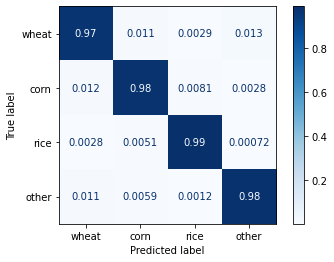

0.9807777777777777

In [18]:
test_single_task_model(y_test, x_test, rot_model, name='normal_rot_model.png')

validation loss has been scaled by: 1.0


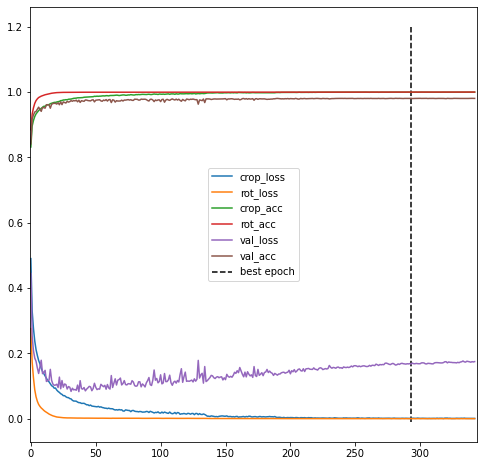

In [27]:
plot_progress(progress.copy(), save=True, name='progress_rot.png')

# Baseline +Time-Segment

In [34]:
def get_seg_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7])
    # trunc: shared part of the model
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

    # head 1 --> tell the sample time-segment partition.
    seg_x = layers.Dense(5, activation='softmax', name='segment')(shared_x)

    # head 2 --> main classifier for crop
    cls_x = layers.Dense(4, activation='softmax', name='crop')(shared_x)

    seg_model = tf.keras.Model(inputs=input_x, outputs=[seg_x, cls_x])
    return seg_model

In [35]:
class SegmentDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, x_unlabeled, batch_size_u=2000, batch_size_s=60):
        self.x_crop = x
        self.y_crop = y
        self.x_unlabeled = x_unlabeled
        self.batch_size_u = batch_size_u
        self.batch_size_s = batch_size_s
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size_u))
    
    def __getitem__(self, index):
        X, Y = self.__prepare_batch(index)
        return X, Y
    
    def on_epoch_end(self):
        ri = np.random.permutation(x_train.shape[0])
        self.x_crop = self.x_crop[ri]
        self.y_crop = self.y_crop[ri]
        np.random.shuffle(self.x_unlabeled)
        
    def __prepare_batch(self, index):
        # rotation task
        x = self.x_unlabeled[index*self.batch_size_u:(index+1)*self.batch_size_u, :, :].copy()
        x_seg_1 = np.repeat(x[:,:2,:], 5, axis=1)
        x_seg_2 = np.repeat(x[:,2:4,:], 5, axis=1)
        x_seg_3 = np.repeat(x[:,4:6,:], 5, axis=1)
        x_seg_4 = np.repeat(x[:,6:8,:], 5, axis=1)
        x_seg_5 = np.repeat(x[:,8:,:], 5, axis=1)
        x_seg = np.concatenate([x_seg_1, x_seg_2, x_seg_3, x_seg_4, x_seg_5])
        y_seg_1 = np.zeros((self.batch_size_u,), dtype='float32')
        y_seg_2 = np.zeros((self.batch_size_u,), dtype='float32') + 1
        y_seg_3 = np.zeros((self.batch_size_u,), dtype='float32') + 2
        y_seg_4 = np.zeros((self.batch_size_u,), dtype='float32') + 3
        y_seg_5 = np.zeros((self.batch_size_u,), dtype='float32') + 4
        y_seg = np.concatenate([y_seg_1, y_seg_2, y_seg_3, y_seg_4, y_seg_5])
        # main task
        x_crop = self.x_crop[index*self.batch_size_s:(index+1)*self.batch_size_s, :, :]
        y_crop = self.y_crop[index*self.batch_size_s:(index+1)*self.batch_size_s]
        # combine with the main task
        n1 = y_crop.shape[0]
        n2 = y_seg.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 5.0
        y_seg = np.concatenate([y_dummy, y_seg])
        # ignore value for crop classification is 4:
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([y_crop, y_dummy])
        X = np.concatenate([x_crop, x_seg])
        Y = [y_seg, y_crop]
        return X, Y

In [38]:
seg_model = get_seg_model()
EPOCHS=1000
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
seg_loss_fn = MaskedCXE(ignore=5)
val_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
seg_acc_metric = MaskedCategoricalAccuracyMetric(ignore=5)
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# datasets and training settings
batch_size = 2**14
train_dataset = SegmentDataGenerator(x=x_train, y=y_train, x_unlabeled=X)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train computation graphs
@tf.function
def train_step(x, y_c, y_s):
    with tf.GradientTape() as tape:
        y_pred_seg, y_pred_crop = seg_model(x, training=True)
        loss_crop = crop_loss_fn(y_c, y_pred_crop)
        loss_seg = seg_loss_fn(y_s, y_pred_seg)
        total_loss = loss_crop + loss_seg + sum(seg_model.losses)
    grads = tape.gradient(total_loss, seg_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, seg_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    seg_acc_metric.update_state(y_s, y_pred_seg)
    return loss_crop, loss_seg

# validation computation graphs
@tf.function
def val_step(x, y):
    _, val_pred = seg_model(x, training=False)
    loss = val_loss_fn(y, val_pred)
    val_acc_metric.update_state(y, val_pred)
    return loss

In [39]:
best_weights = None
max_val_acc = 0.0
counter = 0
val_losses = []
crop_losses = []
seg_losses = []
progress = {'crop_loss':[], 'seg_loss':[], 'crop_acc':[], 'seg_acc':[], 'val_loss':[], 'val_acc':[]}
patience = 25
start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    for step, (x_batch_train, (y_batch_train_seg, y_batch_train_crop)) in enumerate(train_dataset):
        crop_train_loss, seg_train_loss = train_step(x_batch_train, y_batch_train_crop, y_batch_train_seg)
        crop_losses.append(crop_train_loss)
        seg_losses.append(seg_train_loss)
    
    # validation
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)
        val_losses.append(val_loss)
    
    # preserve the best model
    this_epoch_val_acc = val_acc_metric.result().numpy()
    if this_epoch_val_acc > (max_val_acc + 0.000):
        best_weights = seg_model.get_weights()
        max_val_acc = this_epoch_val_acc
        counter = 0
    else:
        counter += 1
    
    # if no progress after patience epochs reduce the learning rate
    if counter >= patience:
        if optimizer.lr.numpy() > 0.00005:
            optimizer.lr = max(0.00005, 0.5 * optimizer.lr.numpy())
            counter = 0
        else:
            break
    
    # Handling metrics and progress
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['seg_loss'].append(np.mean(seg_losses))
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['seg_acc'].append(seg_acc_metric.result().numpy())
    progress['val_acc'].append(val_acc_metric.result().numpy())
    progress['val_loss'].append(np.mean(val_losses))
    
    # reset metrics for the next epoch
    crop_losses = []
    seg_losses = []
    val_losses = []
    crop_acc_metric.reset_states()
    seg_acc_metric.reset_states()
    val_acc_metric.reset_states()
    
   
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print('learning rate: ', optimizer.lr.numpy())
    print('#epochs not improved: ', counter)
    best_epoch = int(np.argmax(progress['val_acc']))
    print("Best Epoch: %d" % (best_epoch+1,))
    print("Best Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)


print(epoch, '/', EPOCHS)
print('learning rate: ', optimizer.lr.numpy())
best_epoch = int(np.argmax(progress['val_acc']))
print("Best Epoch: %d" % (best_epoch+1,))
print("Crop training accuracy: %.4f" % (progress['crop_acc'][best_epoch],))
print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][best_epoch],))
print("Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
print("Validation loss: %.4f" % (progress['val_loss'][best_epoch],))
print("Total training time: %.2fs" % (time.time() - start_time))

261 / 1000
learning rate:  5e-05
Best Epoch: 187
Crop training accuracy: 0.9983
Time-Segment training accuracy: 0.9717
Validation acc: 0.9812
Validation loss: 0.1310
Total training time: 11478.00s


In [41]:
seg_model.set_weights(best_weights)

              precision    recall  f1-score   support

       wheat       0.97      0.97      0.97    270000
        corn       0.98      0.98      0.98    270000
        rice       0.99      0.99      0.99    270000
       other       0.98      0.98      0.98    270000

    accuracy                           0.98   1080000
   macro avg       0.98      0.98      0.98   1080000
weighted avg       0.98      0.98      0.98   1080000



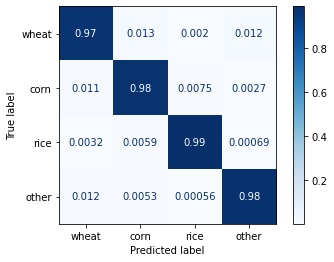

0.9809527777777778

In [42]:
test_single_task_model(y_test, x_test, seg_model, name='normal_seg_model.png')

validation loss has been scaled by: 1.0


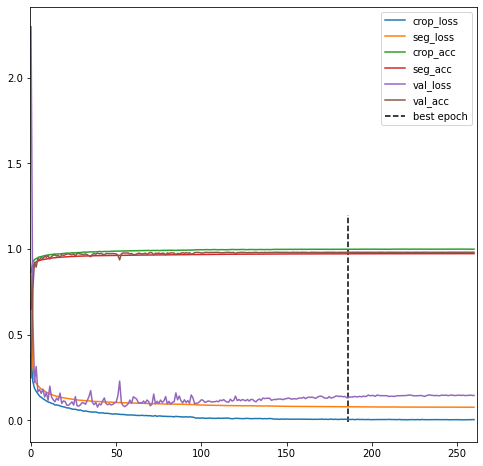

In [45]:
plot_progress(progress.copy(), save=True, name='progress_seg.png')

# Baseline + Band

In [46]:
def get_band_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7])
    # trunc: shared part of the model
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

    # head 1 --> tell the sample band channel
    ban_x = layers.Dense(7, activation='softmax', name='bands')(shared_x)

    # head 2 --> main classifier for crop
    cls_x = layers.Dense(4, activation='softmax', name='crop')(shared_x)

    band_model = tf.keras.Model(inputs=input_x, outputs=[ban_x, cls_x])
    return band_model

In [47]:
class BandDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, x_unlabeled, batch_size_u=2000, batch_size_s=60):
        self.x_crop = x
        self.y_crop = y
        self.x_unlabeled = x_unlabeled
        self.batch_size_u = batch_size_u
        self.batch_size_s = batch_size_s
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size_u))
    
    def __getitem__(self, index):
        X, Y = self.__prepare_batch(index)
        return X, Y
    
    def on_epoch_end(self):
        ri = np.random.permutation(x_train.shape[0])
        self.x_crop = self.x_crop[ri]
        self.y_crop = self.y_crop[ri]
        np.random.shuffle(self.x_unlabeled)
        
    def __prepare_batch(self, index):
        # rotation task
        x = self.x_unlabeled[index*self.batch_size_u:(index+1)*self.batch_size_u, :, :].copy()
        b0 = np.repeat(x[:,:,0:1], 7, axis=-1)
        b1 = np.repeat(x[:,:,1:2], 7, axis=-1)
        b2 = np.repeat(x[:,:,2:3], 7, axis=-1)
        b3 = np.repeat(x[:,:,3:4], 7, axis=-1)
        b4 = np.repeat(x[:,:,4:5], 7, axis=-1)
        b5 = np.repeat(x[:,:,5:6], 7, axis=-1)
        b6 = np.repeat(x[:,:,6:7], 7, axis=-1)
        x_band = np.concatenate([b0, b1, b2, b3, b4, b5, b6])
        y0 = np.zeros((self.batch_size_u,), dtype='float32')
        y1 = np.ones((self.batch_size_u,), dtype='float32')
        y2 = np.ones((self.batch_size_u,), dtype='float32') * 2
        y3 = np.ones((self.batch_size_u,), dtype='float32') * 3
        y4 = np.ones((self.batch_size_u,), dtype='float32') * 4
        y5 = np.ones((self.batch_size_u,), dtype='float32') * 5
        y6 = np.ones((self.batch_size_u,), dtype='float32') * 6    
        y_band = np.concatenate([y0, y1, y2, y3, y4, y5, y6])
        # main task
        x_crop = self.x_crop[index*self.batch_size_s:(index+1)*self.batch_size_s, :, :]
        y_crop = self.y_crop[index*self.batch_size_s:(index+1)*self.batch_size_s]
        # combine with the main task
        n1 = y_crop.shape[0]
        n2 = y_band.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 7.0
        y_band = np.concatenate([y_dummy, y_band])
        # ignore value for crop classification is 4:
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([y_crop, y_dummy])
        X = np.concatenate([x_crop, x_band])
        Y = [y_band, y_crop]
        return X, Y

In [48]:
band_model = get_band_model()
EPOCHS=1000
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
band_loss_fn = MaskedCXE(ignore=7)
val_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
band_acc_metric = MaskedCategoricalAccuracyMetric(ignore=7)
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# datasets and training settings
batch_size = 2**14
train_dataset = BandDataGenerator(x=x_train, y=y_train, x_unlabeled=X)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train computation graphs
@tf.function
def train_step(x, y_c, y_b):
    with tf.GradientTape() as tape:
        y_pred_band, y_pred_crop = band_model(x, training=True)
        loss_crop = crop_loss_fn(y_c, y_pred_crop)
        loss_band = band_loss_fn(y_b, y_pred_band)
        total_loss = loss_crop + loss_band + sum(band_model.losses)
    grads = tape.gradient(total_loss, band_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, band_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    band_acc_metric.update_state(y_b, y_pred_band)
    return loss_crop, loss_band

# validation computation graphs
@tf.function
def val_step(x, y):
    _, val_pred = band_model(x, training=False)
    loss = val_loss_fn(y, val_pred)
    val_acc_metric.update_state(y, val_pred)
    return loss

In [49]:
best_weights = None
max_val_acc = 0.0
counter = 0
val_losses = []
crop_losses = []
band_losses = []
progress = {'crop_loss':[], 'band_loss':[], 'crop_acc':[], 'band_acc':[], 'val_loss':[], 'val_acc':[]}
patience = 25
start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    for step, (x_batch_train, (y_batch_train_band, y_batch_train_crop)) in enumerate(train_dataset):
        crop_train_loss, band_train_loss = train_step(x_batch_train, y_batch_train_crop, y_batch_train_band)
        crop_losses.append(crop_train_loss)
        band_losses.append(band_train_loss)
    
    # validation
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)
        val_losses.append(val_loss)
    
    # preserve the best model
    this_epoch_val_acc = val_acc_metric.result().numpy()
    if this_epoch_val_acc > (max_val_acc + 0.000):
        best_weights = band_model.get_weights()
        max_val_acc = this_epoch_val_acc
        counter = 0
    else:
        counter += 1
    
    # if no progress after patience epochs reduce the learning rate
    if counter >= patience:
        if optimizer.lr.numpy() > 0.00005:
            optimizer.lr = max(0.00005, 0.5 * optimizer.lr.numpy())
            counter = 0
        else:
            break
    
    # Handling metrics and progress
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['band_loss'].append(np.mean(band_losses))
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['band_acc'].append(band_acc_metric.result().numpy())
    progress['val_acc'].append(val_acc_metric.result().numpy())
    progress['val_loss'].append(np.mean(val_losses))
    
    # reset metrics for the next epoch
    crop_losses = []
    band_losses = []
    val_losses = []
    crop_acc_metric.reset_states()
    band_acc_metric.reset_states()
    val_acc_metric.reset_states()
    
   
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print('learning rate: ', optimizer.lr.numpy())
    print('#epochs not improved: ', counter)
    best_epoch = int(np.argmax(progress['val_acc']))
    print("Best Epoch: %d" % (best_epoch+1,))
    print("Best Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)


print(epoch, '/', EPOCHS)
print('learning rate: ', optimizer.lr.numpy())
best_epoch = int(np.argmax(progress['val_acc']))
print("Best Epoch: %d" % (best_epoch+1,))
print("Crop training accuracy: %.4f" % (progress['crop_acc'][best_epoch],))
print("Band training accuracy: %.4f" % (progress['band_acc'][best_epoch],))
print("Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
print("Validation loss: %.4f" % (progress['val_loss'][best_epoch],))
print("Total training time: %.2fs" % (time.time() - start_time))

261 / 1000
learning rate:  5e-05
Best Epoch: 162
Crop training accuracy: 0.9922
Band training accuracy: 0.8856
Validation acc: 0.9690
Validation loss: 0.1820
Total training time: 15295.97s


In [51]:
band_model.set_weights(best_weights)

              precision    recall  f1-score   support

       wheat       0.96      0.96      0.96    270000
        corn       0.97      0.97      0.97    270000
        rice       0.99      0.99      0.99    270000
       other       0.96      0.96      0.96    270000

    accuracy                           0.97   1080000
   macro avg       0.97      0.97      0.97   1080000
weighted avg       0.97      0.97      0.97   1080000



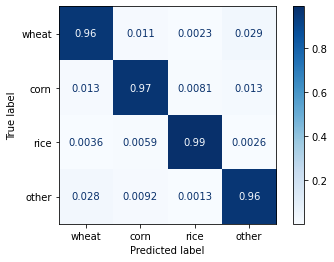

0.968325

In [52]:
test_single_task_model(y_test, x_test, band_model, name='normal_band_model.png')

validation loss has been scaled by: 10.0


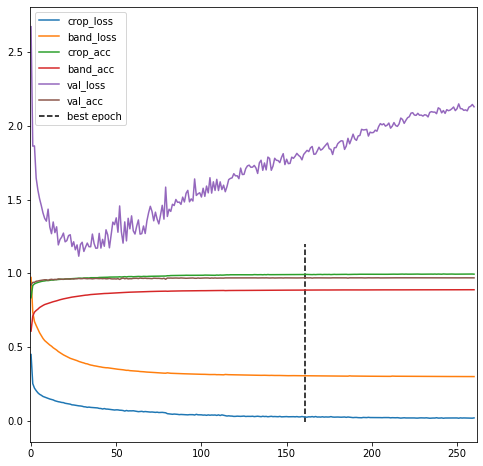

In [53]:
plot_progress(progress.copy(), save=True, name='progress_band.png')

# All Tasks

In [54]:
def get_multitask_model():
    tf.keras.backend.clear_session()
    input_x = layers.Input(shape=[10, 7])
    # trunc: shared part of the model
    shared_x = layers.Conv1D(32, 1, name='conv_1')(input_x)
    shared_x = layers.BatchNormalization(name='bn_1')(shared_x)
    shared_x = layers.LeakyReLU(name='act_1')(shared_x)
    shared_x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, name='lstm_1')(shared_x)
    shared_x = layers.LSTM(64, return_sequences=False, name='lstm_2')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_2')(shared_x)
    shared_x = layers.Dense(32, name='dense_1')(shared_x)
    shared_x = layers.BatchNormalization(name='bn_3')(shared_x)
    shared_x = layers.LeakyReLU(name='act_2')(shared_x)
    shared_x = layers.Dropout(0.25, name='drop_1')(shared_x)

    # head 1 --> tell the sample time-segment partition.
    seg_x = layers.Dense(5, activation='softmax', name='segment')(shared_x)

    # head 2 --> tell the sample band channel
    ban_x = layers.Dense(7, activation='softmax', name='bands')(shared_x)

    # head 3 --> tell the sample rotation
    rot_x = layers.Dense(1, activation='sigmoid', name='rotation')(shared_x)

    # head 4 --> main classifier for crop
    cls_x = layers.Dense(4, activation='softmax', name='crop')(shared_x)

    mt_model = tf.keras.Model(inputs=input_x, outputs=[seg_x, ban_x, rot_x, cls_x])
    return mt_model

In [55]:
class MultiTaskDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, x_unlabeled, batch_size_u=2000, batch_size_s=60):
        self.x_crop = x
        self.y_crop = y
        self.x_unlabeled = x_unlabeled
        self.batch_size_u = batch_size_u
        self.batch_size_s = batch_size_s
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size_u))
    
    def __getitem__(self, index):
        X, Y = self.__prepare_batch(index)
        return X, Y
    
    def on_epoch_end(self):
        ri = np.random.permutation(x_train.shape[0])
        self.x_crop = self.x_crop[ri]
        self.y_crop = self.y_crop[ri]
        np.random.shuffle(self.x_unlabeled)
        
    def __prepare_batch(self, index):
        # main task
        x_crop = self.x_crop[index*self.batch_size_s:(index+1)*self.batch_size_s, :, :]
        y_crop = self.y_crop[index*self.batch_size_s:(index+1)*self.batch_size_s]
        n1 = y_crop.shape[0]
        x = self.x_unlabeled[index*self.batch_size_u:(index+1)*self.batch_size_u, :, :].copy()
        # Bands:
        b0 = np.repeat(x[:,:,0:1], 7, axis=-1)
        b1 = np.repeat(x[:,:,1:2], 7, axis=-1)
        b2 = np.repeat(x[:,:,2:3], 7, axis=-1)
        b3 = np.repeat(x[:,:,3:4], 7, axis=-1)
        b4 = np.repeat(x[:,:,4:5], 7, axis=-1)
        b5 = np.repeat(x[:,:,5:6], 7, axis=-1)
        b6 = np.repeat(x[:,:,6:7], 7, axis=-1)
        x_band = np.concatenate([b0, b1, b2, b3, b4, b5, b6])
        y0 = np.zeros((self.batch_size_u,), dtype='float32')
        y1 = np.ones((self.batch_size_u,), dtype='float32')
        y2 = np.ones((self.batch_size_u,), dtype='float32') * 2
        y3 = np.ones((self.batch_size_u,), dtype='float32') * 3
        y4 = np.ones((self.batch_size_u,), dtype='float32') * 4
        y5 = np.ones((self.batch_size_u,), dtype='float32') * 5
        y6 = np.ones((self.batch_size_u,), dtype='float32') * 6    
        y_band = np.concatenate([y0, y1, y2, y3, y4, y5, y6])
        n2 = y_band.shape[0]
        # Time-Segment:
        x_seg_1 = np.repeat(x[:,:2,:], 5, axis=1)
        x_seg_2 = np.repeat(x[:,2:4,:], 5, axis=1)
        x_seg_3 = np.repeat(x[:,4:6,:], 5, axis=1)
        x_seg_4 = np.repeat(x[:,6:8,:], 5, axis=1)
        x_seg_5 = np.repeat(x[:,8:,:], 5, axis=1)
        x_seg = np.concatenate([x_seg_1, x_seg_2, x_seg_3, x_seg_4, x_seg_5])
        y_seg_1 = np.zeros((self.batch_size_u,), dtype='float32')
        y_seg_2 = np.zeros((self.batch_size_u,), dtype='float32') + 1
        y_seg_3 = np.zeros((self.batch_size_u,), dtype='float32') + 2
        y_seg_4 = np.zeros((self.batch_size_u,), dtype='float32') + 3
        y_seg_5 = np.zeros((self.batch_size_u,), dtype='float32') + 4
        y_seg = np.concatenate([y_seg_1, y_seg_2, y_seg_3, y_seg_4, y_seg_5])
        n3 = y_seg.shape[0]
        # Rotation:
        x_rot = np.concatenate([x[:, ::-1, :], x])
        y_rot = np.ones((self.batch_size_u,), dtype='float32')
        y_not_rot = np.zeros((self.batch_size_u,), dtype='float32')
        y_rotation = np.concatenate([y_rot, y_not_rot])
        n4 = y_rotation.shape[0]
        # combine:
        y_dummy = np.zeros((n2 + n3 + n4,), dtype='float32') + 4.0
        y_crop = np.concatenate([y_crop, y_dummy])
        # ignore value for band classification is 7:
        y_dummy = np.zeros((n1,), dtype='float32') + 7.0
        y_band = np.concatenate([y_dummy, y_band])
        y_dummy = np.zeros((n3 + n4,), dtype='float32') + 7.0
        y_band = np.concatenate([y_band, y_dummy])
        # ignore value for time-segment classification is 5:
        y_dummy = np.zeros((n1 + n2,), dtype='float32') + 5.0
        y_seg = np.concatenate([y_dummy, y_seg])
        y_dummy = np.zeros((n4,), dtype='float32') + 5.0
        y_seg = np.concatenate([y_seg, y_dummy])
        # ignore value for rotation classification is 2:
        y_dummy = np.zeros((n1 + n2 + n3,), dtype='float32') + 2.0
        y_rotation = np.concatenate([y_dummy, y_rotation])
        Y = [y_seg, y_band, y_rotation, y_crop]
        X = np.concatenate([x_crop, x_band, x_seg, x_rot])
        return X, Y

In [71]:
mt_model = get_multitask_model()
EPOCHS=1000
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss functions
crop_loss_fn = MaskedCXE(ignore=4)
band_loss_fn = MaskedCXE(ignore=7)
seg_loss_fn = MaskedCXE(ignore=5)
rot_loss_fn = MaskedBXE()
val_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics
crop_acc_metric = MaskedCategoricalAccuracyMetric(ignore=4)
band_acc_metric = MaskedCategoricalAccuracyMetric(ignore=7)
seg_acc_metric = MaskedCategoricalAccuracyMetric(ignore=5)
rot_acc_metric = MaskedBinaryAccuracyMetric()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# datasets and training settings
batch_size = 2**14
train_dataset = MultiTaskDataGenerator(x=x_train, y=y_train, x_unlabeled=X)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train computation graphs
@tf.function
def train_step(x, y_s, y_b, y_r, y_c):
    with tf.GradientTape() as tape:
        y_pred_seg, y_pred_band, y_pred_rot, y_pred_crop = mt_model(x, training=True)
        loss_crop = crop_loss_fn(y_c, y_pred_crop)
        loss_rot = rot_loss_fn(y_r, y_pred_rot)
        loss_seg = seg_loss_fn(y_s, y_pred_seg)
        loss_band = band_loss_fn(y_b, y_pred_band)
        total_loss = loss_crop + loss_band + loss_rot + loss_seg + sum(mt_model.losses)
    grads = tape.gradient(total_loss, mt_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mt_model.trainable_variables))
    crop_acc_metric.update_state(y_c, y_pred_crop)
    band_acc_metric.update_state(y_b, y_pred_band)
    seg_acc_metric.update_state(y_s, y_pred_seg)
    rot_acc_metric.update_state(y_r, y_pred_rot)
    return loss_seg, loss_band, loss_rot, loss_crop

# validation computation graphs
@tf.function
def val_step(x, y):
    _, _, _, val_pred = mt_model(x, training=False)
    loss = val_loss_fn(y, val_pred)
    val_acc_metric.update_state(y, val_pred)
    return loss

In [72]:
best_weights = None
max_val_acc = 0.0
counter = 0
val_losses = []
crop_losses = []
seg_losses = []
band_losses = []
rot_losses = []
progress = {'crop_loss':[], 'seg_loss':[], 'crop_acc':[], 'seg_acc':[], 'val_loss':[], 'val_acc':[],
           'band_loss':[], 'band_acc':[], 'rot_loss':[], 'rot_acc':[]}
patience = 25
start_time = time.time()
for epoch in range(EPOCHS):
    
    epoch_start_time = time.time()
    for step, (x_b_train, (y_b_seg, y_b_band, y_b_rot, y_b_crop)) in enumerate(train_dataset):
        loss_seg, loss_band, loss_rot, loss_crop = train_step(x_b_train, y_b_seg, y_b_band, y_b_rot, y_b_crop)
        crop_losses.append(loss_crop)
        seg_losses.append(loss_seg)
        band_losses.append(loss_band)
        rot_losses.append(loss_rot)
    
    # validation
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)
        val_losses.append(val_loss)
    
    # preserve the best model
    this_epoch_val_acc = val_acc_metric.result().numpy()
    if this_epoch_val_acc > (max_val_acc + 0.000):
        best_weights = mt_model.get_weights()
        max_val_acc = this_epoch_val_acc
        counter = 0
    else:
        counter += 1
    
    # if no progress after patience epochs reduce the learning rate
    if counter >= patience:
        if optimizer.lr.numpy() > 0.00005:
            optimizer.lr = max(0.00005, 0.5 * optimizer.lr.numpy())
            counter = 0
        else:
            break
    
    # Handling metrics and progress
    progress['crop_loss'].append(np.mean(crop_losses))
    progress['seg_loss'].append(np.mean(seg_losses))
    progress['band_loss'].append(np.mean(band_losses))
    progress['rot_loss'].append(np.mean(rot_losses))
    progress['crop_acc'].append(crop_acc_metric.result().numpy())
    progress['seg_acc'].append(seg_acc_metric.result().numpy())
    progress['band_acc'].append(band_acc_metric.result().numpy())
    progress['rot_acc'].append(rot_acc_metric.result().numpy())
    progress['val_acc'].append(val_acc_metric.result().numpy())
    progress['val_loss'].append(np.mean(val_losses))
    
    # reset metrics for the next epoch
    crop_losses = []
    seg_losses = []
    band_losses = []
    rot_losses = []
    val_losses = []
    crop_acc_metric.reset_states()
    seg_acc_metric.reset_states()
    band_acc_metric.reset_states()
    rot_acc_metric.reset_states()
    val_acc_metric.reset_states()
    
   
    print('training...')
    print(epoch+1, '/', EPOCHS)
    print('learning rate: ', optimizer.lr.numpy())
    print('#epochs not improved: ', counter)
    best_epoch = int(np.argmax(progress['val_acc']))
    print("Best Epoch: %d" % (best_epoch+1,))
    print("Best Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
    print("Time taken: %.2fs" % (time.time() - epoch_start_time))
    clear_output(wait=True)


print(epoch+1, '/', EPOCHS)
print('learning rate: ', optimizer.lr.numpy())
best_epoch = int(np.argmax(progress['val_acc']))
print("Best Epoch: %d" % (best_epoch+1,))
print("Crop training accuracy: %.4f" % (progress['crop_acc'][best_epoch],))
print("Time-Segment training accuracy: %.4f" % (progress['seg_acc'][best_epoch],))
print("Band training accuracy: %.4f" % (progress['band_acc'][best_epoch],))
print("Rotation training accuracy: %.4f" % (progress['rot_acc'][best_epoch],))
print("Validation acc: %.4f" % (progress['val_acc'][best_epoch],))
print("Validation loss: %.4f" % (progress['val_loss'][best_epoch],))
print("Total training time: %.2fs" % (time.time() - start_time))

322 / 1000
learning rate:  5e-05
Best Epoch: 297
Crop training accuracy: 0.9966
Time-Segment training accuracy: 0.9660
Band training accuracy: 0.8907
Rotation training accuracy: 0.9997
Validation acc: 0.9803
Validation loss: 0.1281
Total training time: 35978.14s


In [73]:
mt_model.set_weights(best_weights)

              precision    recall  f1-score   support

       wheat       0.97      0.97      0.97    270000
        corn       0.98      0.98      0.98    270000
        rice       0.99      0.99      0.99    270000
       other       0.98      0.98      0.98    270000

    accuracy                           0.98   1080000
   macro avg       0.98      0.98      0.98   1080000
weighted avg       0.98      0.98      0.98   1080000



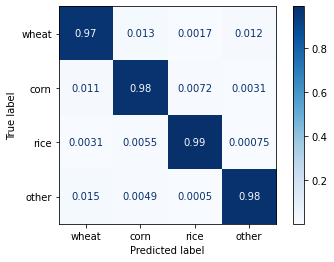

0.980650925925926

In [74]:
test_multitask_model(y_test, x_test, model=mt_model, name='normal_mt_model.png')

validation loss has been scaled by: 1.0


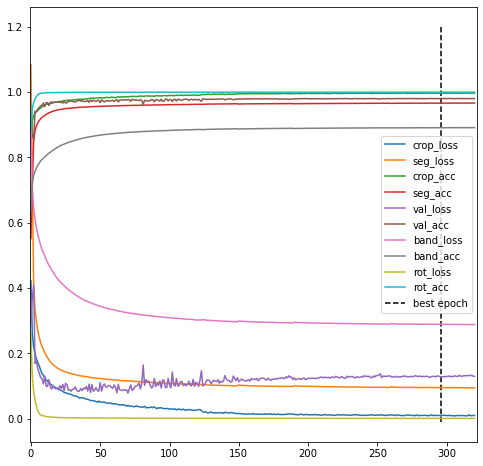

In [75]:
plot_progress(progress.copy(), save=True, name='progress_multitask.png')